# 00. 라이브러리 세팅

In [ ]:
import cv2 # OpenCV
import numpy as np # 행렬 연산 라이브러리
import matplotlib.pyplot as plt # 시각화용 라이브러리

# 01. Image Setting

img1 shape: (4032, 3024, 3), img2 shape: (4032, 3024, 3)


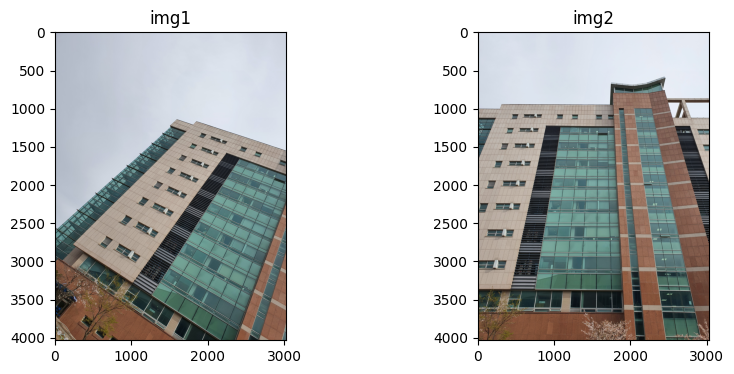

In [41]:
# 이미지 불러오기
img1 = cv2.imread('/home/yamal/ImageStitching/a1.jpg')
img2 = cv2.imread('/home/yamal/ImageStitching/a2.jpg')

# BGR -> RGB 변환
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# 이미지 크기 확인 & 이미지 시각화
print(f"img1 shape: {img1.shape}, img2 shape: {img2.shape}")
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('img1')
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('img2')
plt.show()


# 02. Correspondences 찾기 (특징점 매칭)

### 02-1. SIFT

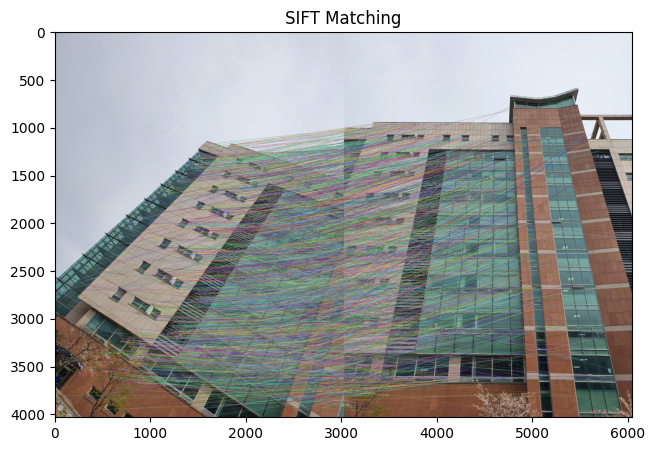

In [42]:
# SIFT 추출기 생성
sift = cv2.SIFT_create()

# 특징점과 특징 디스크립터 계산
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# Brute-Force 매칭, L2 거리로 매칭을 수행
bf = cv2.BFMatcher()

# k=2로 두 번째로 가까운 이웃도 함께 가져와 Lowe ratio test에 사용
matches = bf.knnMatch(des1, des2, k=2)

# Lowe ratio test : 좋은 매칭만 필터링
good = []
pts1 = []
pts2 = []
for m,n in matches:
    # 첫 번째 매칭 거리 < 0.75 * 두 번째 매칭 거리 로 신뢰도 높은 매칭 
    if m.distance < 0.75 * n.distance:
        good.append(m)
        pts1.append(kp1[m.queryIdx].pt)
        pts2.append(kp2[m.trainIdx].pt)

#float32 형 numpy 배열로 변환
pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

#매칭 결과를 이미지로 시각화
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good, None, flags=2)
plt.figure(figsize=(15, 5))
plt.imshow(img_matches)
plt.title('SIFT Matching')
plt.show()

### 02-2. ORB

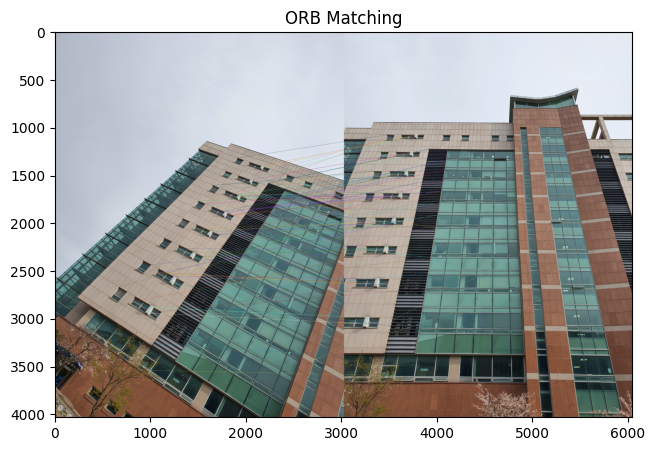

In [43]:
# ORB 추출기 생성
orb = cv2.ORB_create()

# 특징점과 특징 디스크립터 계산
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Hamming 거리 기반 매칭, 교차 검증 설정으로 정확도 향상
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# 매칭 거리가 작은 순서대로 정렬
matches = sorted(matches, key=lambda x: x.distance)

# 매칭된 키 포인트 좌표 배열 생성
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

# 상위 100개 매칭만 시각화
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=2)
plt.figure(figsize=(15, 5))
plt.imshow(img_matches)
plt.title('ORB Matching')
plt.show()

### 02-3. 수동 찾기

In [20]:
# manual_point_selector.py 로 생성된 매칭된 대응점 불러오기
pts1 = np.load("pts1.npy")
pts2 = np.load("pts2.npy")

# 대응점 불러오기 확인, 점 개수 확인
print("수동 대응점 불러오기 완료:")
print("pts1.shape =", pts1.shape)
print("pts2.shape =", pts2.shape)

수동 대응점 불러오기 완료:
pts1.shape = (15, 2)
pts2.shape = (15, 2)


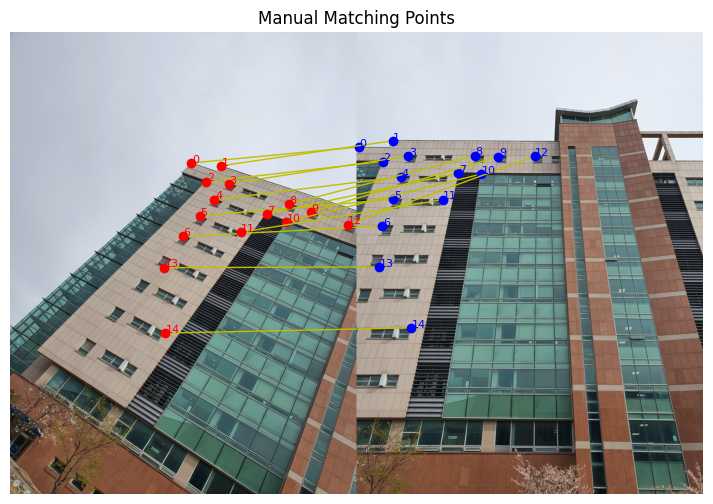

In [ ]:
# 대응점, 매칭 시각화
img1_display = cv2.imread('/home/yamal/ImageStitching/a1.jpg')
img2_display = cv2.imread('/home/yamal/ImageStitching/a2.jpg')
img1_display = cv2.cvtColor(img1_display, cv2.COLOR_BGR2RGB)
img2_display = cv2.cvtColor(img2_display, cv2.COLOR_BGR2RGB)

# 이미지 크기 조정
h = min(img1_display.shape[0], img2_display.shape[0])
img1_display = cv2.resize(img1_display, (int(img1_display.shape[1] * h / img1_display.shape[0]), h))
img2_display = cv2.resize(img2_display, (int(img2_display.shape[1] * h / img2_display.shape[0]), h))
combined = np.hstack((img1_display, img2_display))
w1 = img1_display.shape[1]

# 매칭된 점 시각화
fig, ax = plt.subplots(figsize=(14, 6))
ax.imshow(combined)
for i, (p1, p2) in enumerate(zip(pts1, pts2)):
    pt1 = (int(p1[0] * h / img1.shape[0]), int(p1[1] * h / img1.shape[0]))
    pt2 = (int(p2[0] * h / img2.shape[0]) + w1, int(p2[1] * h / img2.shape[0]))
    ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'y-', linewidth=1)
    ax.plot(pt1[0], pt1[1], 'ro')
    ax.plot(pt2[0], pt2[1], 'bo')
    ax.text(pt1[0]+5, pt1[1]-5, str(i), color='red', fontsize=8)
    ax.text(pt2[0]+5, pt2[1]-5, str(i), color='blue', fontsize=8)
ax.set_title("Manual Matching Points")
ax.axis("off")
plt.show()

# 03. Homography 계산

### 03-1. OpenCV 라이브러리 사용

In [44]:
# OpenCV RANSAC 기반 Homography
# RANSAC으로 이상치(outlier)를 제거하여 Homography 추정
H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC)
print("Homography Matrix (cv2):\n", H)

Homography Matrix (cv2):
 [[ 1.53712527e+00  6.94321409e-01 -3.21839774e+03]
 [-3.04956224e-01  1.53739699e+00  5.65028973e+01]
 [ 1.55638865e-04  8.04415863e-05  1.00000000e+00]]


### 03-2. 직접 계산 (DLT)

In [ ]:
# DLT 알고리즘으로 Homography 직접 계산
def compute_homography(src_pts, dst_pts):
    A = []
    # 각 대응점 쌍에 대해 방정식 생성
    # H * [x, y, 1] = [x', y', 1] 형태로 변환
    for (x, y), (x_p, y_p) in zip(src_pts, dst_pts):
        A.append([-x, -y, -1, 0, 0, 0, x*x_p, y*x_p, x_p])
        A.append([0, 0, 0, -x, -y, -1, x*y_p, y*y_p, y_p])
    A = np.array(A) # A 행렬 생성

    # SVD 분해
    _, _, Vt = np.linalg.svd(A) # A = U * S * Vt
    # Vt의 마지막 행을 Homography 행렬로 사용
    H = Vt[-1].reshape(3, 3) 
    return H / H[2,2] # Homography 행렬 정규화

H_manual = compute_homography(pts1.reshape(-1,2), pts2.reshape(-1,2))
print("Homography Matrix (Manual):\n", H_manual)

Homography Matrix (Manual):
 [[-4.87467986e-01 -4.44222964e-01  1.71625592e+03]
 [-7.39941870e-01 -7.63704662e-01  2.76596433e+03]
 [-2.85680066e-04 -2.64369892e-04  1.00000000e+00]]


# 04. 이미지 Warping

### 04-1. OpenCV 라이브러리로 Warping (Backward & bilinear 보간)

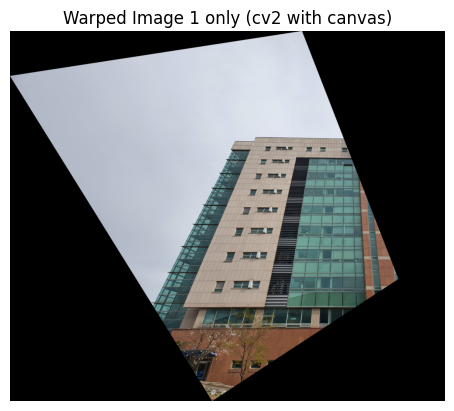

In [46]:
# img2의 경계와 Homography를 통해 변환된 img1의 경계를 합쳐 전체 캔버스 크기 계산
height, width = img2.shape[:2]
corners_img1 = np.array([[0,0], [img1.shape[1],0], [img1.shape[1],img1.shape[0]], [0,img1.shape[0]]], dtype='float32')
warped_corners = cv2.perspectiveTransform(corners_img1[None], H)[0]
all_corners = np.vstack((warped_corners, [[0,0], [width,0], [width,height], [0,height]]))

# 최소 최대 좌표 추출
[x_min, y_min] = np.int32(all_corners.min(axis=0))
[x_max, y_max] = np.int32(all_corners.max(axis=0))

# 이미지를 이동시킬 변환 행렬
translate = [-x_min, -y_min]
trans_mat = np.array([[1, 0, translate[0]], [0, 1, translate[1]], [0, 0, 1]])

# warped 생성, warped 된 img1 시각화
warped = cv2.warpPerspective(img1, trans_mat @ H, (x_max - x_min, y_max - y_min))
plt.imshow(warped)
plt.title('Warped Image 1 only (cv2 with canvas)')
plt.axis('off')
plt.show()

### 04-2. Backward Warping 직접 계산 (Nearest)

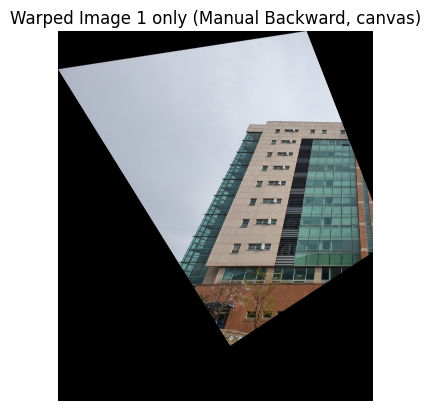

In [ ]:
height, width = img2.shape[:2] 
corners_img1 = np.array([[0,0], [img1.shape[1],0], [img1.shape[1],img1.shape[0]], [0,img1.shape[0]]], dtype='float32')
warped_corners = cv2.perspectiveTransform(corners_img1[None], H)[0]
all_corners = np.vstack((warped_corners, [[0,0], [width,0], [width,height], [0,height]]))
[x_min, y_min] = np.int32(all_corners.min(axis=0))
[x_max, y_max] = np.int32(all_corners.max(axis=0))

translate = [-x_min, -y_min]
trans_mat = np.array([[1, 0, translate[0]], [0, 1, translate[1]], [0, 0, 1]])


def backward_warp(img, H, shape):
    # H_inv는 역행렬
    H_inv = np.linalg.inv(H)
    out = np.zeros(shape, dtype=img.dtype)  # 캔버스 크기만큼 0으로 초기화
    for y in range(shape[0]):  
        for x in range(shape[1]):
            pt = np.array([x, y, 1.0])
            pt_mapped = H_inv @ pt # 역행렬을 곱하여 원본 이미지에서의 좌표 계산
            pt_mapped /= pt_mapped[2] # 동차 좌표로 변환
            x_, y_ = pt_mapped[:2] # x_, y_는 원본 이미지에서의 좌표
            # 좌표가 이미지 범위 내에 있는지 확인
            if 0 <= int(x_) < img.shape[1] and 0 <= int(y_) < img.shape[0]:
                out[y, x] = img[int(y_), int(x_)]
    return out

warped = backward_warp(img1, trans_mat @ H, (x_max - x_min, y_max - y_min, 3))
plt.imshow(warped)
plt.title('Warped Image 1 only (Manual Backward, canvas)')
plt.axis('off')
plt.show()

### 04-3. Forward warping 직접 계산

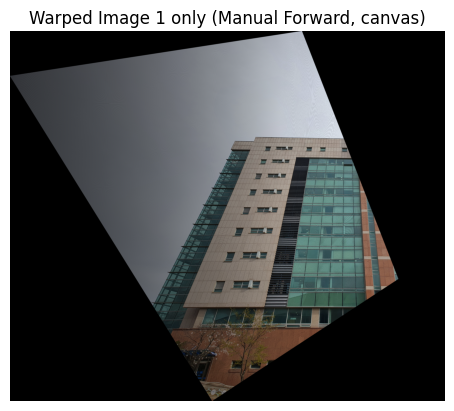

In [ ]:
height, width = img2.shape[:2]
corners_img1 = np.array([[0,0], [img1.shape[1],0], [img1.shape[1],img1.shape[0]], [0,img1.shape[0]]], dtype='float32')
warped_corners = cv2.perspectiveTransform(corners_img1[None], H)[0]
all_corners = np.vstack((warped_corners, [[0,0], [width,0], [width,height], [0,height]]))
[x_min, y_min] = np.int32(all_corners.min(axis=0))
[x_max, y_max] = np.int32(all_corners.max(axis=0))

translate = [-x_min, -y_min]
trans_mat = np.array([[1, 0, translate[0]], [0, 1, translate[1]], [0, 0, 1]])

def forward_warp(img, H, shape):
    out = np.zeros(shape, dtype=img.dtype) # 캔버스 크기만큼 0으로 초기화
    # H는 변환 행렬, img는 원본 이미지
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            pt = np.array([x, y, 1.0]) # 원본 이미지에서의 좌표
            # 변환 행렬을 곱하여 새로운 좌표 계산
            pt_mapped = H @ pt
            pt_mapped /= pt_mapped[2] # 동차 좌표로 변환
            # pt_mapped는 변환된 좌표
            x_, y_ = int(pt_mapped[0]), int(pt_mapped[1])   # x_, y_는 변환된 좌표
            # 좌표가 캔버스 범위 내에 있는지 확인
            if 0 <= x_ < shape[1] and 0 <= y_ < shape[0]:
                out[y_, x_] = img[y, x]
    return out

warped = forward_warp(img1, trans_mat @ H, (y_max - y_min, x_max - x_min, 3))
plt.imshow(warped)
plt.title('Warped Image 1 only (Manual Forward, canvas)')
plt.axis('off')
plt.show()

# 05. Image Stitching

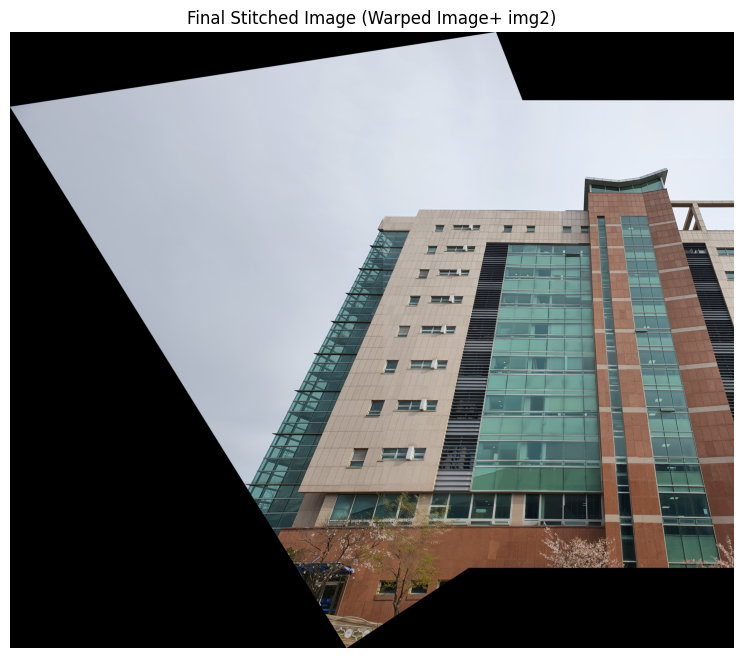

In [47]:
# 빈 캔버스 생성 및 img2를 안전하게 삽입
canvas = np.zeros_like(warped)

# 안전한 범위 계산 (canvas 범위를 넘지 않도록!)
y_start = translate[1]
x_start = translate[0]
y_end = min(y_start + img2.shape[0], canvas.shape[0])
x_end = min(x_start + img2.shape[1], canvas.shape[1])

canvas[y_start:y_end, x_start:x_end] = img2[0:y_end - y_start, 0:x_end - x_start]

#두 이미지를 픽셀별 최대값 방식으로 합침
stitched = np.maximum(warped, canvas)

plt.figure(figsize=(10, 8))
plt.imshow(stitched)
plt.title("Final Stitched Image (Warped Image+ img2)")
plt.axis('off')
plt.show()
